<a href="https://colab.research.google.com/github/isurushanaka/ICARC2025-Tutorial/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WSN based Indoor Localization**

### Preamble

In [ ]:
import warnings

# Hide FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

UJIIndoorLoc: [Paper Link](https://ieeexplore.ieee.org/document/7275492/similar#similar) / [Dataset Link](https://archive.ics.uci.edu/dataset/310/ujiindoorloc)

In [ ]:
!wget https://archive.ics.uci.edu/static/public/310/ujiindoorloc.zip

--2025-02-10 08:07:48--  https://archive.ics.uci.edu/static/public/310/ujiindoorloc.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘ujiindoorloc.zip.1’

ujiindoorloc.zip.1      [ <=>                ]   1.40M  7.35MB/s    in 0.2s    

2025-02-10 08:07:48 (7.35 MB/s) - ‘ujiindoorloc.zip.1’ saved [1463759]



In [ ]:
!unzip /content/ujiindoorloc.zip

Archive:  /content/ujiindoorloc.zip
replace UJIndoorLoc/trainingData.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: UJIndoorLoc/trainingData.csv  
replace UJIndoorLoc/validationData.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: UJIndoorLoc/validationData.csv  


# Dataset

In [125]:
training_data_path = "/content/UJIndoorLoc/trainingData.csv"
test_data_path = "/content/UJIndoorLoc/validationData.csv"

In [144]:
import pandas as pd

train_df = pd.read_csv(training_data_path)
test_df = pd.read_csv(test_data_path)
train_df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683
19933,100,100,100,100,100,100,100,100,100,100,...,100,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402
19934,100,100,100,100,100,100,100,100,100,100,...,100,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921
19935,100,100,100,100,100,100,100,100,100,100,...,100,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049


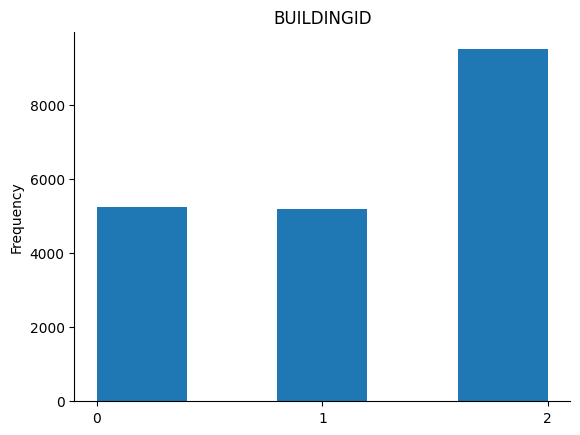

In [140]:
from matplotlib import pyplot as plt
train_df['BUILDINGID'].plot(kind='hist', bins=5, title='BUILDINGID')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(np.arange(min(train_df['BUILDINGID']), max(train_df['BUILDINGID'])+1, 1))  # Set step to 2
plt.show()

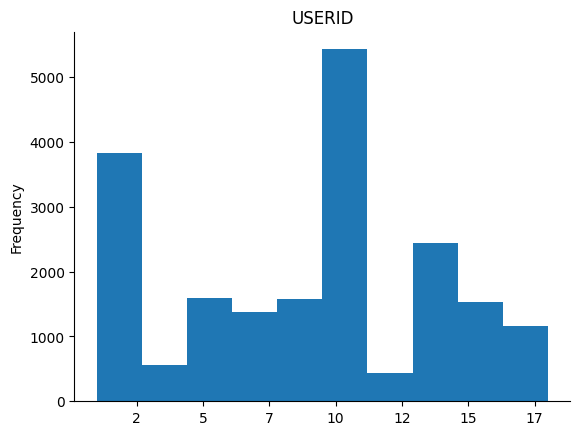

In [143]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

train_df['USERID'].plot(kind='hist', bins=10, title='USERID')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))  # For x-axis
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d'))  # For y-axis

plt.show()

# Data Preprocessing

### 1. Label Encoding

In [ ]:
# new unique identifier by combining these two columns (BUILDINGID, FLOOR)

train_df['Unique_SPACEID'] = train_df['BUILDINGID'].astype(str) + '_' + train_df['FLOOR'].astype(str)
test_df['Unique_SPACEID'] = test_df['BUILDINGID'].astype(str) + '_' + test_df['FLOOR'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # Initialize the encoder

encoder.fit(train_df['Unique_SPACEID']) # Fit the encoder on training data

# Transform training data
train_df['Unique_SPACEID'] = encoder.transform(train_df['Unique_SPACEID'])

# Transform validation data
# Assign -1 for unknown labels
test_df['Unique_SPACEID'] = test_df['Unique_SPACEID'].apply(lambda x:encoder.transform([x])[0] if x in encoder.classes_ else -1)

In [ ]:
train_df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,Unique_SPACEID
0,100,100,100,100,100,100,100,100,100,100,...,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,6
1,100,100,100,100,100,100,100,100,100,100,...,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,6
2,100,100,100,100,100,100,100,-97,100,100,...,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,6
3,100,100,100,100,100,100,100,100,100,100,...,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,6
4,100,100,100,100,100,100,100,100,100,100,...,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683,7
19933,100,100,100,100,100,100,100,100,100,100,...,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402,9
19934,100,100,100,100,100,100,100,100,100,100,...,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921,7
19935,100,100,100,100,100,100,100,100,100,100,...,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049,7


In [ ]:
print(train_df['Unique_SPACEID'].nunique())
print(test_df['Unique_SPACEID'].nunique())

13
13


### 2. Data Normalization

* Using Min-Max Normalization (Scale to [0,1]): Min-Max scaling ensures that all values are transformed to a range between 0 and 1.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Initialize the scaler

# Apply StandardScaler to the RSSI columns of the train data
train_df.iloc[:, :520] = scaler.fit_transform(train_df.iloc[:, :520])

# Transform validation data using the same scaler
test_df.iloc[:, :520] = scaler.transform(test_df.iloc[:, :520])

* Using Standardization (Zero Mean, Unit Variance): Standardization scales values to have a mean of 0 and standard deviation of 1.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Initialize the scaler

# Apply StandardScaler to the first 520 columns
train_df.iloc[:, :520] = scaler.fit_transform(train_df.iloc[:, :520])

# Transform test data using the same scaler
test_df.iloc[:, :520] = scaler.transform(test_df.iloc[:, :520])

In [ ]:
train_df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,Unique_SPACEID
0,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,6
1,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,6
2,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,-5.780754,0.175093,0.066191,...,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,6
3,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,6
4,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683,7
19933,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402,9
19934,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921,7
19935,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049,7


In [ ]:
X_train, y_train = train_df.iloc[:, :520], train_df["Unique_SPACEID"]
X_test, y_test = test_df.iloc[:, :520], test_df["Unique_SPACEID"]

In [ ]:
X_train

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
1,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
2,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,-5.780754,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
3,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
4,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
19933,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
19934,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0
19935,0.03006,0.030884,0,0,0.044834,0.125136,0.172437,0.187211,0.175093,0.066191,...,0.29991,0.026499,0.078752,0.079722,0.054926,0.422218,0.541602,0.033231,0.012267,0


In [ ]:
y_train

,Unique_SPACEID
0,6
1,6
2,6
3,6
4,0
...,...
19932,7
19933,9
19934,7
19935,7


# Machine Learning Models

| Model	                          |Pros	                                     |Cons                                     |
| :-------------------------------|:-----------------------------------------|:----------------------------------------|
| Logistic Regression	          |Simple, interpretable	                 |Assumes linear separability              |
| k-NN	                          |No training phase, easy to implement	     |Slow for large datasets                  |
| Decision Tree	                  |Handles complex patterns, interpretable   |Prone to overfitting                     |
| Naïve Bayes	                  |Works well for text classification	     |Assumes feature independence             |
| Random Forest                   |More robust and less prone to overfitting |Computationally expensive                |
| SVM	                          |Good for high-dimensional data	         |Slow on large datasets                   |

# Training

### 1. Logistic Regression
* A linear model for binary / multiclass classification.
* Works best when data is linearly separable.

In [ ]:
from sklearn.linear_model import LogisticRegression
LGR = LogisticRegression(max_iter=100)
LGR.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 2. k-Nearest Neighbors (k-NN)
* A non-parametric model that classifies a data point based on the majority class of its k nearest neighbors.
* Sensitive to noise and computationally expensive for large datasets.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

KNeighborsClassifier()

### 3. Decision Tree
* A tree-based model that makes decisions based on feature splits.
* Can overfit easily, so pruning or setting a maximum depth is recommended.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(max_depth=10)
DTC.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

### 4. Naïve Bayes
* A probabilistic model based on Bayes' theorem.
* Works best for text classification and when features are independent.

In [ ]:
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(X_train, y_train)

GaussianNB()

### 5. Random Forest Classifier
* An ensemble learning method that combines multiple decision trees to improve classification accuracy and reduce overfitting.
* Works by creating multiple decision trees during training and averaging their predictions (majority voting for classification).
* More robust and less prone to overfitting than a single decision tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100)
RFC.fit(X_train, y_train)

RandomForestClassifier()

### 6. Support Vector Machine (SVM)
* Finds the best hyperplane to separate classes.
* Uses kernel trick to handle non-linear classification.
* Works well with high-dimensional data.

In [ ]:
from sklearn.svm import SVC
SVM = SVC(kernel='linear')
SVM.fit(X_train, y_train)

SVC(kernel='linear')

# Evaluation

#### 1. Accuracy
$$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Predictions}}
$$
* Accuracy measures the proportion of correct predictions (both true positives and true negatives) out of the total predictions made

#### 2. Precision
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$
* Precision measures the proportion of true positive predictions out of all positive predictions

#### 3. Recall
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$
* Recall (also known as Sensitivity or True Positive Rate) measures the proportion of true positive predictions out of all actual positive instances

#### 4. F1 Score
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
* The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 1. Logistic Regression

In [ ]:
y_pred = LGR.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')

Accuracy : 0.7471
Precision: 0.7797
Recall   : 0.7471
F1 Score : 0.7491


### 2. k-Nearest Neighbors (k-NN)

In [ ]:
y_pred = KNN.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')

Accuracy : 0.6562
Precision: 0.7169
Recall   : 0.6562
F1 Score : 0.6602


### 3. Decision Tree

In [ ]:
y_pred = DTC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')

Accuracy : 0.6184
Precision: 0.7454
Recall   : 0.6184
F1 Score : 0.6251


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4. Naïve Bayes

In [ ]:
y_pred = NBC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')

Accuracy : 0.3645
Precision: 0.4523
Recall   : 0.3645
F1 Score : 0.3372


### 5. Random Forest Classifier

In [ ]:
y_pred = RFC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')

Accuracy : 0.8704
Precision: 0.8949
Recall   : 0.8704
F1 Score : 0.8717


### 6. Support Vector Machine (SVM)

In [ ]:
y_pred = SVM.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')

Accuracy : 0.7381
Precision: 0.7706
Recall   : 0.7381
F1 Score : 0.7398


# Graphs

### Function for Plotting the Results

In [ ]:
def get_decoded_sapceid(df):
  # Create a function to reverse the transformation
  def decode_unique_spaceid(encoded_value):
      decoded_value = encoder.inverse_transform([encoded_value])[0]
      building_id, floor = decoded_value.split('_')
      return int(building_id), int(floor)

  decode_df = pd.DataFrame()
  # Apply the function to get BUILDINGID and FLOOR
  decode_df[['Decoded_BUILDINGID', 'Decoded_FLOOR']] = df['Unique_SPACEID'].apply(decode_unique_spaceid).apply(pd.Series)
  return decode_df

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_results(y_test,y_pred,plot_label="Predicted Vs Actual"):
  predd_df = pd.DataFrame(y_pred, columns=['Unique_SPACEID'])
  testd_df = pd.DataFrame(y_test, columns=['Unique_SPACEID'])

  # Create the scatter plot
  fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

  # Plot predictions
  ax.scatter(get_decoded_sapceid(predd_df)['Decoded_BUILDINGID'], get_decoded_sapceid(predd_df)['Decoded_FLOOR'],
              label='Predictions', alpha=0.5, marker='o', s=100)  # Customize markers

  # Plot actual values
  ax.scatter(get_decoded_sapceid(testd_df)['Decoded_BUILDINGID'], get_decoded_sapceid(testd_df)['Decoded_FLOOR'],
              label='Actual Values', alpha=0.5, marker='x', s=300)  # Customize markers

  ax.set_xlabel('BUILDINGID')
  ax.set_ylabel('FLOOR')
  ax.set_title(f'{plot_label}')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))
  ax.legend()
  ax.grid(True)
  plt.show()

### 1. Logistic Regression

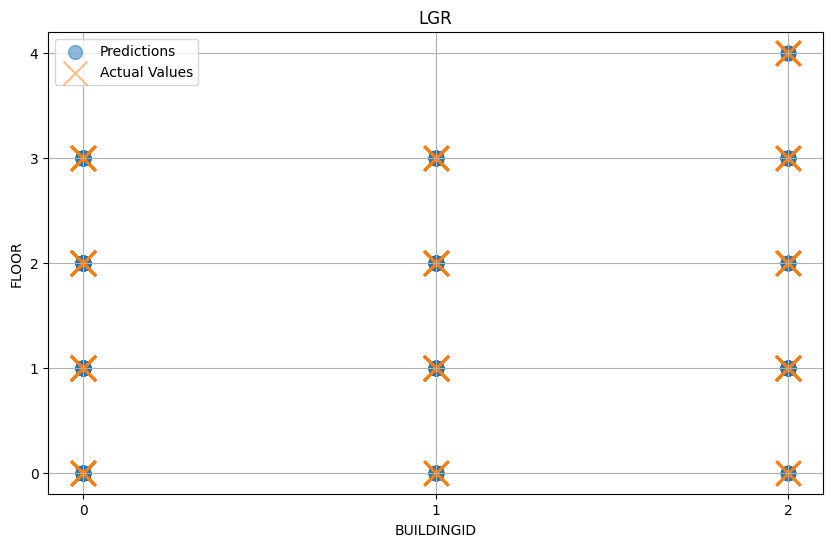

In [ ]:
plot_results(y_test, LGR.predict(X_test), plot_label="LGR")

### 2. k-Nearest Neighbors (k-NN)

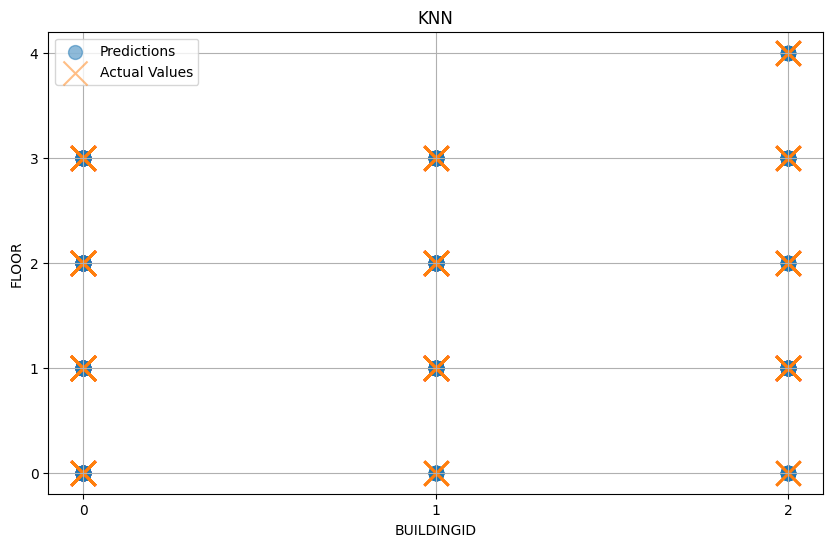

In [ ]:
plot_results(y_test, KNN.predict(X_test), plot_label="KNN")

### 3. Decision Tree

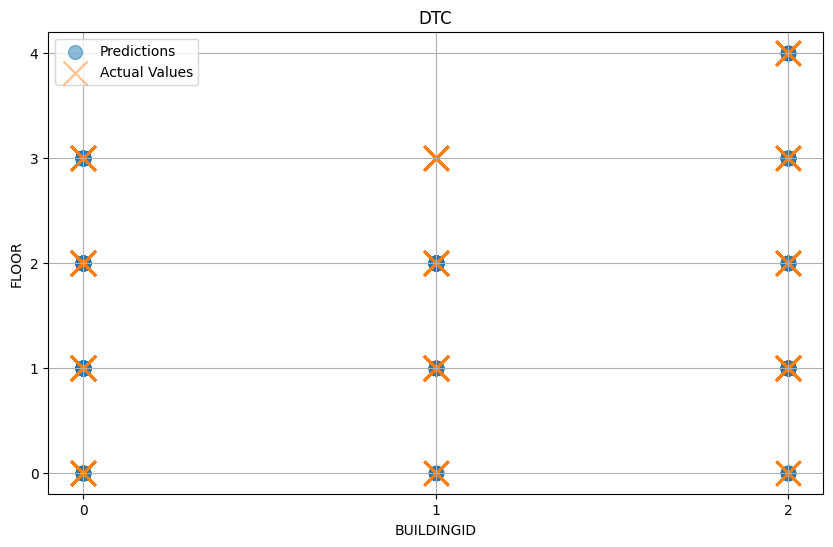

In [ ]:
plot_results(y_test, DTC.predict(X_test), plot_label="DTC")

### 4. Naïve Bayes

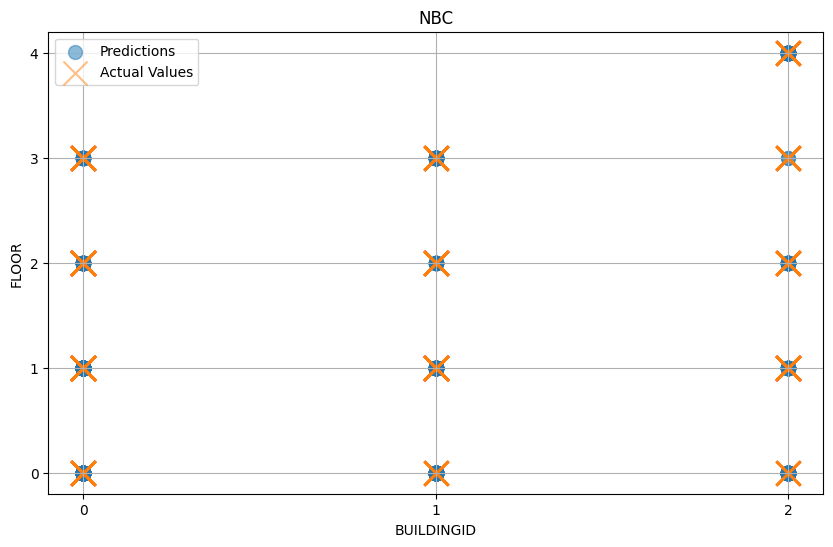

In [ ]:
plot_results(y_test, NBC.predict(X_test), plot_label="NBC")

### 5. Random Forest Classifier

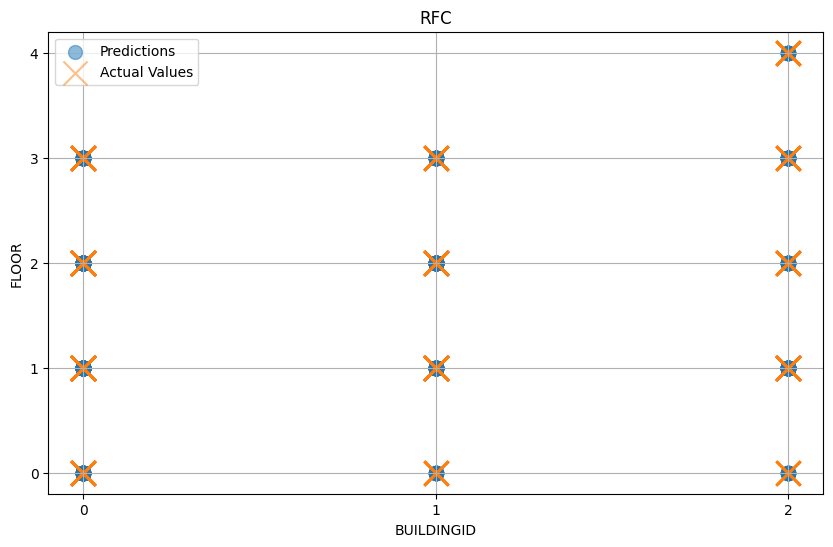

In [ ]:
plot_results(y_test, RFC.predict(X_test), plot_label="RFC")

### 6. Support Vector Machine (SVM)

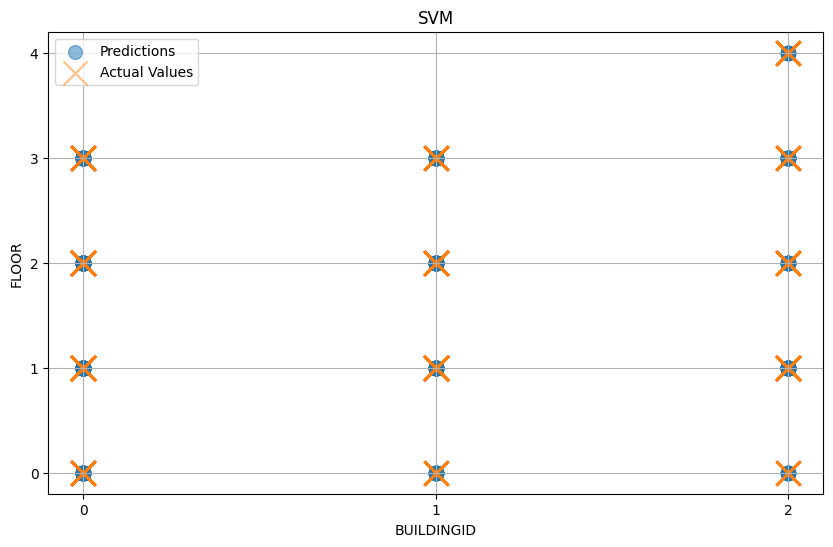

In [ ]:
plot_results(y_test, SVM.predict(X_test), plot_label="SVM")

# Special Models

## 1. SVM
* Train SVM models with different kernels (linear, poly, rbf, sigmoid)

In [ ]:
from sklearn.svm import SVC
kernels = ['linear', 'poly', 'rbf', 'sigmoid'] # List of kernels
results = {} # Dictionary to store evaluation metrics

LINEAR


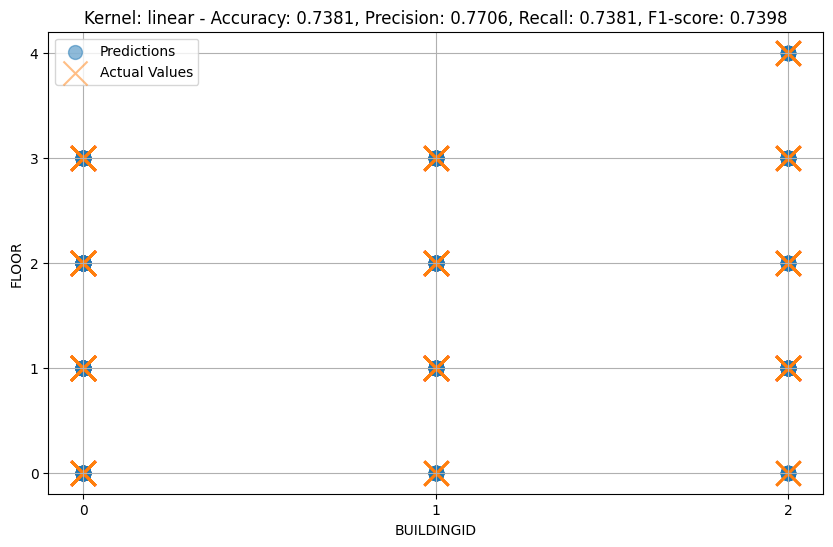

POLY


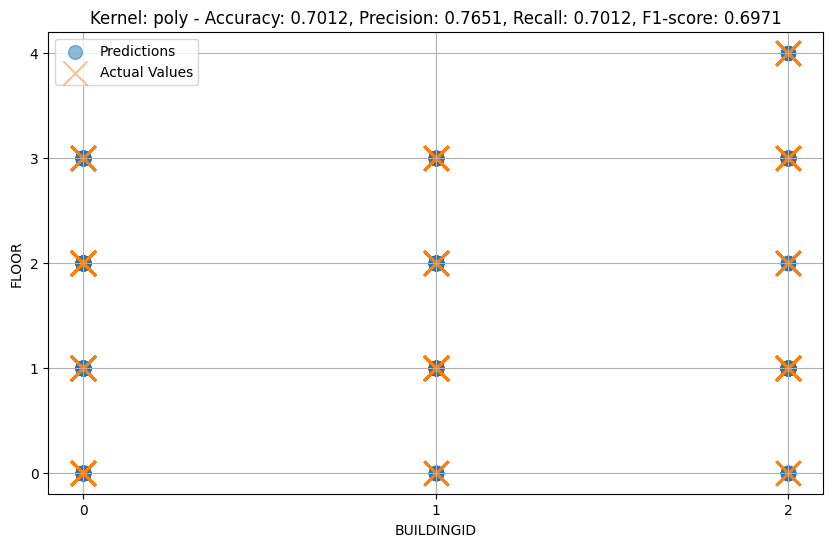

RBF


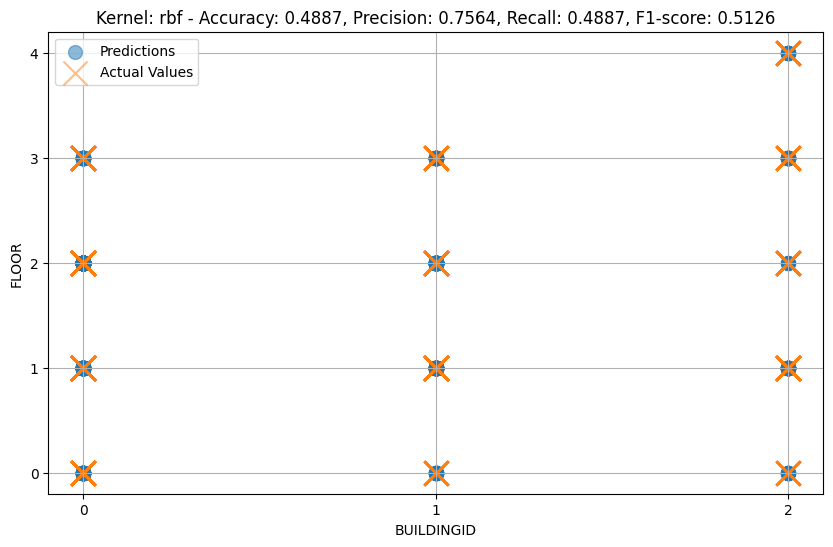

SIGMOID


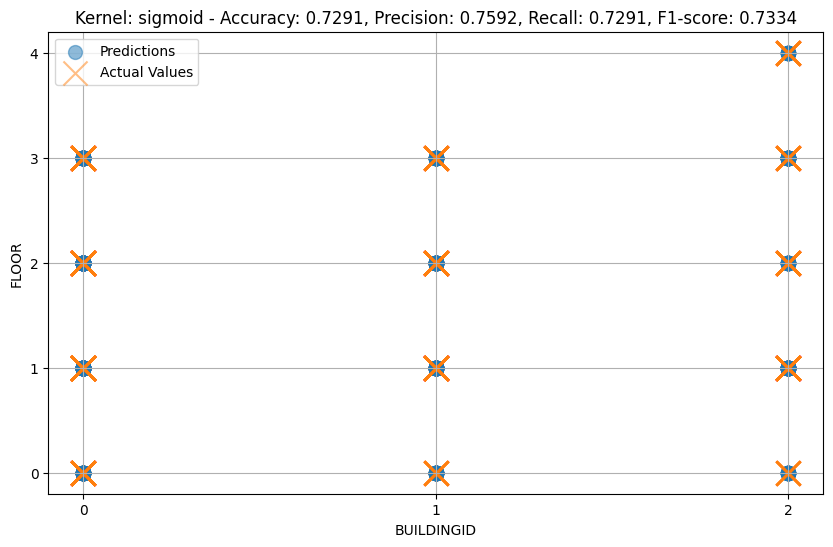

In [ ]:
for kernel in kernels:
    print(f"{kernel.upper()}")

    model = SVC(kernel=kernel, random_state=42) # Initialize SVM model
    model.fit(X_train, y_train) # Train the model
    y_pred = model.predict(X_test) # Make predictions

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # plot results
    results[kernel] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
    str = f"Kernel: {kernel} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}"

    plot_results(y_test, y_pred, plot_label=str)


## 2. Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the Neural Network Model
model = keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(520,)),  # Input Layer
    layers.Dense(128, activation="relu"),  # Hidden Layer
    layers.Dense(64, activation="relu"),  # Hidden Layer
    layers.Dense(32, activation="relu"),  # Hidden Layer
    layers.Dense(len(np.unique(y_train)), activation="softmax")  # Output Layer
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7458 - loss: 0.7566 - val_accuracy: 0.5104 - val_loss: 9.1901
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9498 - loss: 0.1411 - val_accuracy: 0.4950 - val_loss: 8.3036
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9640 - loss: 0.0981 - val_accuracy: 0.5005 - val_loss: 8.9821
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9724 - loss: 0.0763 - val_accuracy: 0.5329 - val_loss: 8.0329
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9764 - loss: 0.0662 - val_accuracy: 0.4986 - val_loss: 8.2062
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9744 - loss: 0.0776 - val_accuracy: 0.5041 - val_loss: 7.7332
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9818 - loss: 0.0544 - val_accuracy: 0.5293 - val_loss: 6.5386
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9797 - loss: 0.0717 - val_accuracy: 0.

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average="weighted")
recall = recall_score(y_test, y_pred_classes, average="weighted")
f1 = f1_score(y_test, y_pred_classes, average="weighted")

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy : 0.5140
Precision: 0.7000
Recall   : 0.5140
F1 Score : 0.5538


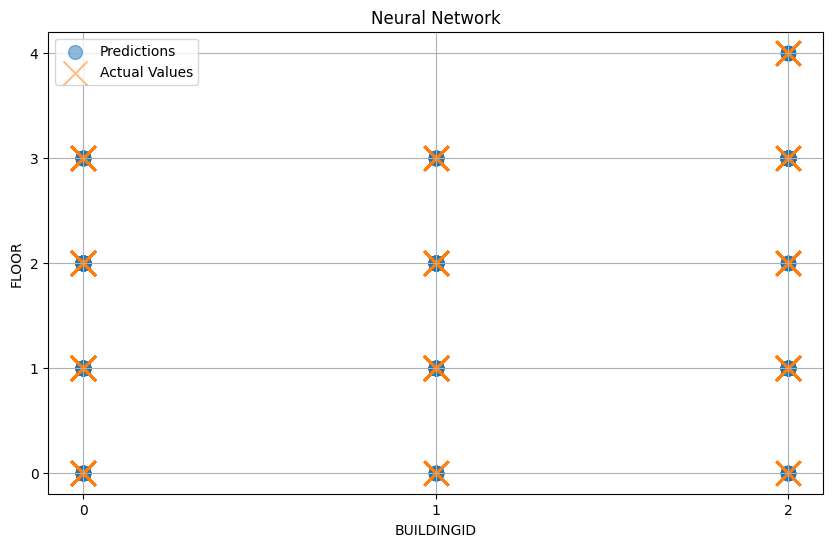

In [ ]:
plot_results(y_test, y_pred_classes, plot_label="Neural Network")